In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import _pickle as pickle
import seaborn as sns
import pymysql
from scipy.stats import wasserstein_distance

In [2]:
visit_probability = {}
for visit_id, prob in np.array(pd.read_csv('../data/rfr_model_depth_69_trees_190_preds.csv', header=None)):
    visit_probability[int(visit_id)] = prob
    
len(visit_probability)

1573113

In [3]:
colors = sns.color_palette("colorblind", 6).as_hex()

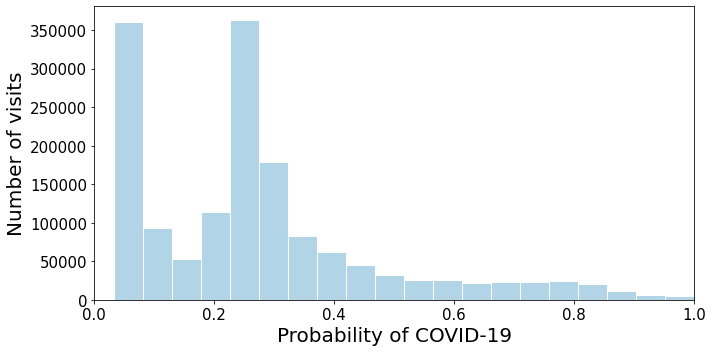

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(x=visit_probability.values(), bins=20,  
             color=colors[0], alpha=0.3, 
             edgecolor='white')
plt.xlim(0,1)
plt.ylabel('Number of visits', size=20)
plt.xlabel('Probability of COVID-19', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('figure_4_a_full_distribution.pdf')
plt.show()

In [5]:
positive_training_set = pickle.load(open('../data/positive_training_set.p', 'rb'))
positive_eval_set = pickle.load(open('../data/positive_eval_set.p', 'rb'))
u071_set = positive_eval_set + positive_training_set

In [6]:
data_to_plot = pd.DataFrame([['u07.1', visit_probability[i]] for i in u071_set]+
                            [['nonu07.1', visit_probability[i]] for i in set(visit_probability.keys())-set(u071_set)],
                            columns=['set', 'prob'])

In [7]:
len(data_to_plot['prob'][data_to_plot['set']=='u07.1'])

9340

In [8]:
wasserstein_distance(data_to_plot['prob'][data_to_plot['set']=='u07.1'], data_to_plot['prob'][data_to_plot['set']!='u07.1'])

0.46946260278532737

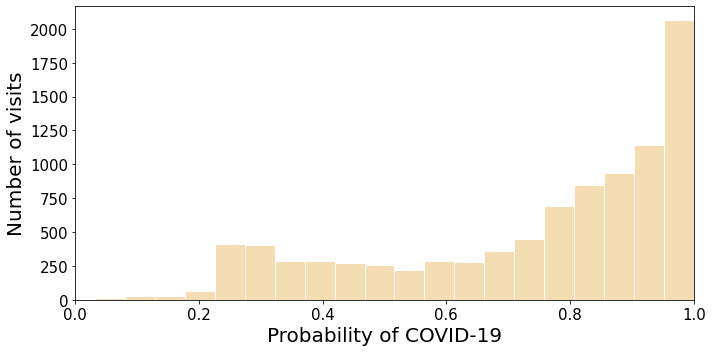

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data_to_plot, x='prob', hue='set', bins=20, hue_order=['u07.1'],
             palette=[colors[1]], alpha=0.3, legend=False,
             edgecolor='white')
plt.xlim(0,1)
plt.ylabel('Number of visits', size=20)
plt.xlabel('Probability of COVID-19', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('figure_4_b_covid_diag.pdf')
plt.show()

In [10]:
# start tunnel first: ssh -f [uni]@mimir.dbmi.columbia.edu -L 3307:127.0.0.1:3306 -N

conn = pymysql.connect(host="127.0.0.1", 
                       user="vr2430", #uni
                       port = 60419,
                       passwd="B0p1ElM7hT", #sql password
                       db = "clinical_merge_v5_2020q4" ) #database
cur = conn.cursor()

In [11]:
cur.execute('''select distinct visit_id, pat_mrn_id
               from user_vr2430.vfinal_1_predict_covid_visits
               join covid_measurements using (pat_mrn_id)
               where (proc_id in (400660,400670,400671,400834,400662,400833,400620,400697,400747,400571,400661,400570) 
                       or component_id in (36079,36100,36101,36105,36137,36189,36308,36309, 36072, 36074, 36081, 36176, 36177, 36182, 36183, 36342) 
                       or component_loinc_code = 94500)
               and ord_value in ('Detected', 'POSITIVE', 'Yes', 'DETECTED', 'YES', 'Detected..', 'Postive', 'Positive','Detected A')
               and ordering_date >= st_dt and ordering_date <= ed_dt;''')

covid_pos_test_visit = [list(i) for i in cur.fetchall()]

covid_pos_test_visit = np.array(pd.DataFrame(covid_pos_test_visit))
len(covid_pos_test_visit), len(set(covid_pos_test_visit[:,0])), len(set(covid_pos_test_visit[:,1]))

(18156, 18156, 16550)

In [12]:
cur.execute('''select distinct visit_id, pat_mrn_id
               from user_vr2430.vfinal_1_predict_covid_visits
               join covid_measurements using (pat_mrn_id)
               where (proc_id in (400660,400670,400671,400834,400662,400833,400620,400697,400747,400571,400661,400570) 
                       or component_id in (36079,36100,36101,36105,36137,36189,36308,36309, 36072, 36074, 36081, 36176, 36177, 36182, 36183, 36342) 
                       or component_loinc_code = 94500)
               and ordering_date >= st_dt and ordering_date <= ed_dt
               and ord_value in ('Not Detected', 'NotDetectd', 'Negative', 'SARS-CoV-2 neg', 'Not Detected (External)', 'neg', 'Non detected', 'Not Dectected', 'Undetected', 'Negatvie', 'NOT_DETECT', 'notdetected', 'Not Deteceted', 'ND', 'Note Detected', 'not dtected', 'not  detected', 'non-detected', 'not deted', 'Nogative', 'NOPT DETECTED', 'neative', 'No Detected', 'Non-reactive');''')

covid_neg_test_visit = [list(i) for i in cur.fetchall()]

covid_neg_test_visit = np.array(pd.DataFrame(covid_neg_test_visit))
len(covid_neg_test_visit), len(set(covid_neg_test_visit[:,0])), len(set(covid_neg_test_visit[:,1]))

(238444, 238444, 130750)

In [13]:
cur.execute('''select distinct visit_id, pat_mrn_id
               from covid_patients
               join user_vr2430.vfinal_1_predict_covid_visits using (pat_mrn_Id)
               where contact_date >= st_dt and contact_date <= ed_dt
               and icd10_desc like 'COVID-19 ruled out%';''')

covid_ruled_out = [list(i) for i in cur.fetchall()]
covid_ruled_out = np.array(pd.DataFrame(covid_ruled_out))
len(covid_ruled_out)

168

In [14]:
cur.execute('''select distinct visit_id, pat_mrn_id
               from covid_patients
               join user_vr2430.vfinal_1_predict_covid_visits using (pat_mrn_Id)
               where contact_date >= st_dt and contact_date <= ed_dt
               and (icd10_code like '%Z86.16%' or icd10_code like '%Z86.19%');''')

covid_history = [list(i) for i in cur.fetchall()]
covid_history = np.array(pd.DataFrame(covid_history))
len(covid_history)

901

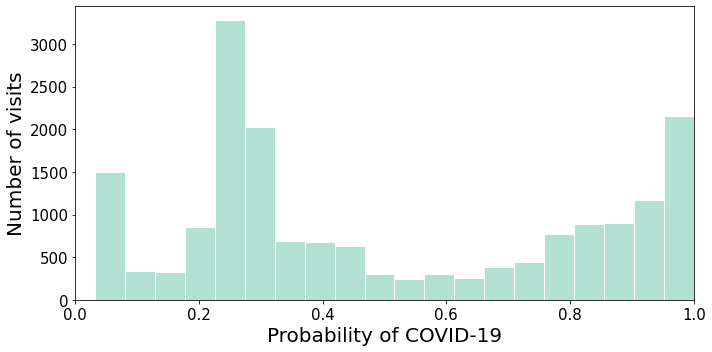

In [15]:
data_to_plot = pd.DataFrame([[1, visit_probability[i]] for i in set(covid_pos_test_visit[:,0])]+
                            [[0, visit_probability[i]] for i in set(visit_probability.keys())-set(covid_pos_test_visit[:,0])],
                            columns=['set', 'prob'])
plt.figure(figsize=(10, 5))
sns.histplot(data=data_to_plot, x='prob', hue='set', bins=20, hue_order=[1],
             palette=[colors[2]], alpha=0.3, legend=False,
             edgecolor='white')
plt.xlim(0,1)
plt.ylabel('Number of visits', size=20)
plt.xlabel('Probability of COVID-19', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('figure_4_c_sars_pos.pdf')
plt.show()

In [16]:
len(data_to_plot['prob'][data_to_plot['set']==1]), wasserstein_distance(data_to_plot['prob'][data_to_plot['set']==1], data_to_plot['prob'][data_to_plot['set']!=1])

(18156, 0.2318652595512878)

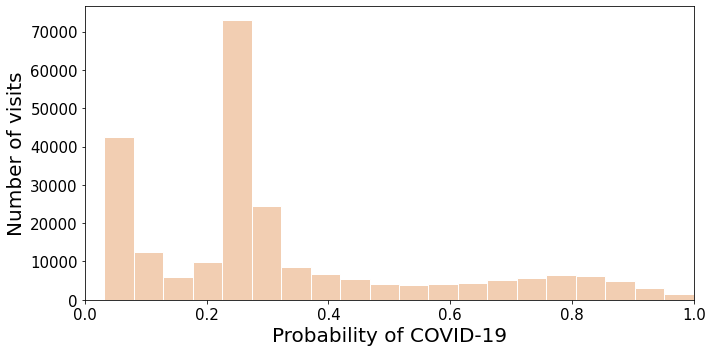

In [17]:
data_to_plot = pd.DataFrame([[1, visit_probability[i]] for i in set(visit_probability.keys())&set(covid_neg_test_visit[:,0])]+
                            [[0, visit_probability[i]] for i in set(visit_probability.keys())-set(covid_neg_test_visit[:,0])],
                            columns=['set', 'prob'])
plt.figure(figsize=(10, 5))
sns.histplot(data=data_to_plot, x='prob', hue='set', bins=20, hue_order=[1],
             palette=[colors[3]], alpha=0.3, legend=False,
             edgecolor='white')
plt.xlim(0,1)
plt.ylabel('Number of visits', size=20)
plt.xlabel('Probability of COVID-19', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('figure_4_d_sars_neg.pdf')
plt.show()

In [18]:
len(data_to_plot['prob'][data_to_plot['set']==1]), wasserstein_distance(data_to_plot['prob'][data_to_plot['set']==1], data_to_plot['prob'][data_to_plot['set']!=1])

(238438, 0.055046971452157194)

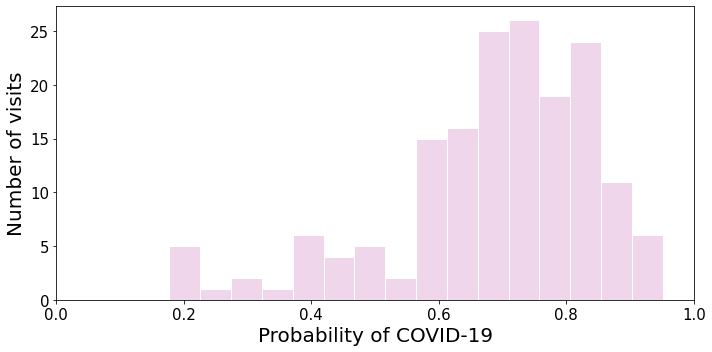

In [19]:
data_to_plot = pd.DataFrame([[1, visit_probability[i]] for i in set(visit_probability.keys())&set(covid_ruled_out[:,0])]+
                            [[0, visit_probability[i]] for i in set(visit_probability.keys())-set(covid_ruled_out[:,0])],
                            columns=['set', 'prob'])
plt.figure(figsize=(10, 5))
sns.histplot(data=data_to_plot, x='prob', hue='set', bins=20, hue_order=[1],
             palette=[colors[4]], alpha=0.3, legend=False,
             edgecolor='white')
plt.xlim(0,1)
plt.ylabel('Number of visits', size=20)
plt.xlabel('Probability of COVID-19', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('figure_4_e_covid_ruled_out.pdf')
plt.show()

In [20]:
len(data_to_plot['prob'][data_to_plot['set']==1]), wasserstein_distance(data_to_plot['prob'][data_to_plot['set']==1], data_to_plot['prob'][data_to_plot['set']!=1])

(168, 0.41575574902836754)

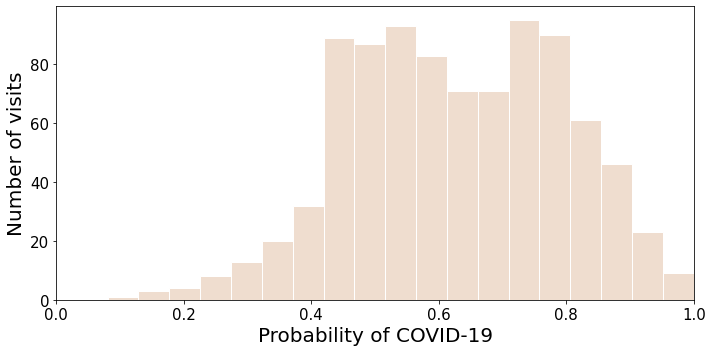

In [21]:
data_to_plot = pd.DataFrame([[1, visit_probability[i]] for i in set(visit_probability.keys())&set(covid_history[:,0])]+
                            [[0, visit_probability[i]] for i in set(visit_probability.keys())-set(covid_history[:,0])],
                            columns=['set', 'prob'])
plt.figure(figsize=(10, 5))
sns.histplot(data=data_to_plot, x='prob', hue='set', bins=20, hue_order=[1],
             palette=[colors[5]], alpha=0.3, legend=False,
             edgecolor='white')
plt.xlim(0,1)
plt.ylabel('Number of visits', size=20)
plt.xlabel('Probability of COVID-19', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('figure_4_f_covid_history.pdf')
plt.show()

In [22]:
len(data_to_plot['prob'][data_to_plot['set']==1]), wasserstein_distance(data_to_plot['prob'][data_to_plot['set']==1], data_to_plot['prob'][data_to_plot['set']!=1])

(899, 0.35472830299231906)